In [3]:
import torch
from torch import nn
from torch.nn import functional as F

import sys
sys.path.append("..")

from typing import Tuple
from matplotlib import pyplot as plt
from math import sqrt

from transformer.modules import clone_module

%matplotlib inline

## Decoder Masks

In [4]:
def subsequent_mask(size: int) -> torch.Tensor:
    """
    """
    attn_shape = (1, size, size)
    sub_mask = torch.triu(
        torch.ones(size=attn_shape, dtype=torch.uint8),
        diagonal=1
    )
    return sub_mask == 0

In [5]:
subsequent_mask(3)[0]

tensor([[ True, False, False],
        [ True,  True, False],
        [ True,  True,  True]])

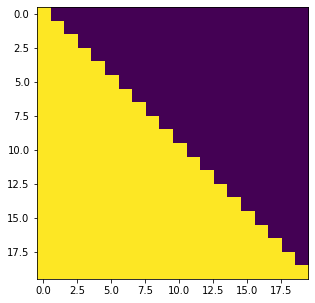

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(20)[0]);

<h2 align="center">Attention</h2>

>An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the qury with the corresponding key.

<h3 align="center">Scaled Dot-Product Attention</h3>
<div align="center">
    <div>
        <img src="images/attention.png" alt="scaled dot product attention" />
    </div>
    <div>
        attention(Q, K, V) = matmul(softmax(matmul(Q, K.t) / sqrt(d_k)), V)
    </div>
</div>
<div>
    <ol>
        <li>The input consists of queries and keys of dimension d_k, and values of d_v.</li>
        <li>We compute the dot products of the query with all keys, divide each by `sqrt(d_k)`, and apply a softmax function to obtain weights for the values.</li>
        <li>Mask is optional.</li>
        <li>Optionally we also add a dropout layer on attention weights.</li>
    </ol>
</div>

> While for small values of d_k the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of d_k.  
> Intuition: For large values of d_k. the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients. Scaling is done to counteract this.

In [7]:
def attention(query: torch.Tensor, key: torch.Tensor,
              value: torch.Tensor, mask: torch.Tensor = None,
              dropout: nn.Module = None) -> Tuple[torch.Tensor, torch.Tensor]:
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
        / sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -float("inf"))
    attention_probs = softmax(scores, dim=-1)
    if dropout is not None:
        attention_probs = dropout(attention_probs)
    return torch.matmul(attention_probs, value), attention_probs

<h2 align="center">Multi-head Attention</h2>

<div align="center">
    <img src="images/multiheadattention.png" alt="Multi-head attention diagram" />
</div>

>Instead of performing a single attention function with d_model - dimensional keys, values, and queries, we found it beneficial to linearly project the queries, keys, and values *h* times with different, learned linear projections to d_k, d_k, and d_v dimensions respectively.

<div>
    <ul>
        <li>On each of these projected versions of Q, K, V, we perform attention function in parallel, yielding <i>d_v</i>-dimensional output values <i>h</i> times.</li>
        <li>MHA allows the model to jointly attend to information from different representation subspaces at different positions.</li>
        <div align="center">
            <h3>MultiHead(Q, K, V) = matmul(concat(head<sub>1</sub>, head<sub>2</sub>, ..., head<sub>h</sub>), W<sup>O</sup>)</h3>
            <h4>head<sub>i</sub> = Attention(QW<sup>Q</sup><sub>i</sub>, KW<sup>K</sup><sub>i</sub>, VW<sup>V</sup><sub>i</sub>)</h4>
        </div>
        <li>We use <i>h = 8</i> parallel attention layers, or heads.</li>
        <li>And we use d_k = d_v = d_model/h = 64</li>
    </ul>
</div>


In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, h: int, d_model: int, dropout_prob: float = 0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clone_module(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # linear projection using first 3 linears
        # last one is for combined output
        query, key, value = [
            l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for l, x in zip( self.linears, (query, key, value))
        ]

        context_vector, self.attn = attention(
            query=query, key=key,
            value=value, mask=mask,
            dropout=self.dropout
        )

        context_vector = context_vector.transpose(1, 2).contiguous()\
                                       .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](context_vector)

Still don't have: 
* Embeddings
* Position-wise feed forward
* Positional encoding